# How to Run This Notebook (Important for Students)

To run this tutorial, please follow these steps:

### **Step 1 — Download the .ipynb file**
Go to the GitHub repository and click:
**Code → Download ZIP**  
or download the notebook directly using  
**Download raw file**.

### **Step 2 — Open Google Colab**
Go to: https://colab.research.google.com  
You must be logged into your Google account.

### **Step 3 — Upload the notebook**
In Colab, select:
**File → Upload Notebook → Choose file → Select the .ipynb file you downloaded**

The notebook will open in Colab, and you can now run the cells one by one.




Google Colab ## Step 1: Setup and data loading

In this tutorial, we work with a dataset of public comments submitted in response to a Centers for Medicare & Medicaid Services (CMS) policy proposal. Each row in the dataset represents one comment, and the columns contain the comment text along with various pieces of metadata (for example, identifiers, timestamps, and information about the commenter or the docket). The main column we will use throughout the tutorial is:

- `comment_text` — a cleaned version of the original public comment, represented as plain text.

Our goal in this notebook is to demonstrate several methods for analyzing these comments using modern natural language processing (NLP) tools in Python. Before we do any analysis, however, we need to:

1. Import the core Python libraries we will rely on for data manipulation, plotting, text processing, and working with local LLM models.
2. Load the CMS comments data from a CSV file hosted on GitHub.
3. Quickly inspect the structure of the data frame (its columns and a few example rows) to verify that the file loaded correctly and to remind ourselves what information is available.

The code cell below imports the necessary libraries, reads the CSV file into a pandas data frame called `comments`, and prints the column names and the first few rows so that we can see the layout of the dataset.


In [ ]:
# ----------------------------------------------------------
# STEP 1: Import core Python libraries
# ----------------------------------------------------------
# We start by importing the core libraries that we will use throughout
# the tutorial. These libraries provide tools for data manipulation,
# plotting, numerical computation, text processing, and working with
# local/open-source LLM models.

import pandas as pd             # Data manipulation (similar to dplyr/readr in R)
import seaborn as sns           # High-level plotting (similar to ggplot2 in R)
import matplotlib.pyplot as plt # Core plotting library (needed to save/tweak plots)
import numpy as np              # Numerical operations (arrays, vectors, matrices)
import nltk                     # Natural Language Toolkit (for text processing)
from transformers import pipeline # For local/open-source Transformer-based models

# -----------------------------------------------------------------------------
# 1. SETUP & DATA LOADING
# -----------------------------------------------------------------------------
# In this section, we load the CMS public comments dataset from a CSV file.
# The file is hosted on GitHub, so we read it directly from a URL.
# The resulting data frame is stored in the object `comments`.

# In R, you would use `read_csv()` from readr. In Python, we use pandas (`pd.read_csv()`).
url = "https://raw.githubusercontent.com/kanattossekbayev-cyber/Tutorial-Methods/refs/heads/main/cms_comments_10k.csv"

# Read the CSV file from the URL into a pandas DataFrame named `comments`.
comments = pd.read_csv(url)

# After loading the data, it is good practice to inspect the structure.
# `comments.columns` is similar to `names(df)` in R and shows the variable names.
print("Column names:", comments.columns)

# `head()` works similarly to R: it prints the first few rows of the data frame.
# Here we request the first 3 rows to verify that the data loaded correctly.
print(comments.head(3))


Column names: Index(['Unnamed: 0', 'Document.ID', 'Agency.ID', 'Docket.ID',
       'Tracking.Number', 'Document.Type', 'Posted.Date', 'Is.Withdrawn.',
       'Federal.Register.Number', 'FR.Citation', 'Title', 'Comment.Start.Date',
       'Comment.Due.Date', 'Allow.Late.Comments', 'Comment.on.Document.ID',
       'Effective.Date', 'Implementation.Date', 'Postmark.Date',
       'Received.Date', 'Author.Date', 'Related.RIN.s.', 'Authors', 'CFR',
       'Abstract', 'Legacy.ID', 'Media', 'Document.Subtype',
       'Exhibit.Location', 'Exhibit.Type', 'Additional.Field.1',
       'Additional.Field.2', 'Topics', 'Duplicate.Comments',
       'OMB.PRA.Approval.Number', 'Page.Count', 'Page.Length', 'Paper.Width',
       'Special.Instructions', 'Source.Citation', 'Start.End.Page', 'Subject',
       'First.Name', 'Last.Name', 'City', 'State.Province', 'Zip.Postal.Code',
       'Country', 'Organization.Name', 'Submitter.Representative',
       'Representative.s.Address', 'Representative.s.City..Stat

## Step 2: Data cleaning and selection of key variables

Before applying any NLP methods, we first need to clean the dataset and focus on the variables that are most important for our analysis. In the original CMS comments file, there are many columns, but in this tutorial we only need two of them:

- a unique identifier for each comment, and  
- the actual text of the comment.

In this step, we create a cleaned version of the dataset called `comments_clean`. We perform three main operations:

1. **Rename variables** to more convenient names:
   - `Document.ID` → `comment_id`
   - `Comment` → `comment_text`
2. **Select only the columns we need**: the comment ID and the comment text.
3. **Remove empty or missing comments**, so that all rows in `comments_clean` contain non-empty text that can be analyzed.

The code cell below carries out these steps using pandas. This is similar in spirit to using `select()` and `filter()` in dplyr in R, but implemented with method chaining in Python.


In [ ]:
# -----------------------------------------------------------------------------
# 2. DATA CLEANING (dplyr-style operations in pandas)
# -----------------------------------------------------------------------------
# In this section, we create a cleaned version of the dataset that keeps
# only the columns we need and removes rows with missing or empty text.
#
# In R, you might write something like:
#   comments %>%
#     select(comment_id = Document.ID, comment_text = Comment) %>%
#     filter(!is.na(comment_text), comment_text != "")
#
# In Python, we achieve the same result using pandas method chaining.

comments_clean = (
    comments
    # 1) Rename columns to more convenient names
    #    Here we map the original variable names to new names:
    #    "Document.ID" becomes "comment_id"
    #    "Comment" becomes "comment_text"
    .rename(columns={
        "Document.ID": "comment_id",
        "Comment": "comment_text"
    })
    # 2) Select only the columns we care about:
    #    the unique comment identifier and the comment text.
    [["comment_id", "comment_text"]]
    # 3) Drop rows where comment_text is missing (NaN).
    #    This is similar to filter(!is.na(comment_text)) in R.
    .dropna(subset=["comment_text"])
)

# 4) Further filter out rows where comment_text is an empty string.
#    By default, pandas does not treat "" as missing, so we explicitly remove it.
comments_clean = comments_clean[comments_clean["comment_text"] != ""]

# Print the first few rows of the cleaned data to verify the result.
print("Cleaned Data Head:")
print(comments_clean.head(3))


Cleaned Data Head:
            comment_id                                       comment_text
0  CMS-2023-0144-11709  Centers for Medicare & Medicaid Services and D...
1  CMS-2023-0144-38142  Centers for Medicare & Medicaid Services and D...
2   CMS-2023-0144-1542  The Center for  Medicare & Medicaid Services,\...


## Step 3: Tokenization and sentiment lexicon loading

Before we apply any sentiment scoring methods, we need to load the lexical resources that will help us analyze the content of each comment. In this step, we use the **Opinion Lexicon**, a widely used positive/negative word list that is conceptually similar to the “bing” sentiment lexicon in R (used in tidytext).

The Opinion Lexicon contains two key lists:

- **positive words** — terms generally associated with favorable sentiment  
- **negative words** — terms generally associated with unfavorable sentiment  

Loading these lexicons allows us to perform simple lexicon-based analyses, check word frequencies, and understand which sentiment-bearing words appear most often in the CMS comments.

We also download NLTK’s tokenizer resources (`punkt`) so that comments can be split into words when needed. After loading the lexicon, we convert the lists into Python **sets**, which allow for much faster lookups when checking whether a word is positive or negative.


In [ ]:
# -----------------------------------------------------------------------------
# 3. TOKENIZATION & LEXICON LOADING
# -----------------------------------------------------------------------------
# In this section, we download and load the "Opinion Lexicon", which provides
# lists of positive and negative sentiment words. This lexicon is similar to
# the "bing" sentiment lexicon commonly used in tidytext in R.
#
# We also download the NLTK tokenizer resources needed to break comments
# into individual words (tokens).

# Download the Opinion Lexicon word lists (positive and negative sentiment words)
nltk.download('opinion_lexicon', quiet=True)

# Download tokenizer data (used to split text into words)
nltk.download('punkt', quiet=True)

# Additional tokenizer resource needed by some NLTK versions
nltk.download('punkt_tab')

from nltk.corpus import opinion_lexicon

# The Opinion Lexicon provides lists of positive and negative words.
# We convert these lists into Python sets because set membership checks
# (e.g., `word in positive_words`) are significantly faster than lists.

positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# At this stage, we now have two sentiment lexicons loaded:
# - positive_words  (many hundreds of positive sentiment terms)
# - negative_words  (many hundreds of negative sentiment terms)
#
# These can be used later to compute lexicon-based sentiment measures
# or to inspect which sentiment-bearing words appear in the comments.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Step 4: Calculating simple lexicon-based sentiment scores

Now that we have loaded a positive and negative sentiment lexicon, we can construct a simple lexicon-based sentiment score for each comment. The idea is straightforward:

1. **Tokenize** the comment text into individual words.
2. **Count** how many of those words appear in the positive lexicon.
3. **Count** how many appear in the negative lexicon.
4. **Compute a net sentiment score** as:  
   \[
   \text{sentiment\_score} = \text{(# positive words)} - \text{(# negative words)}
   \]

This approach is conceptually similar to what we might do in R with `unnest_tokens()` and joins to a sentiment lexicon (for example, using `inner_join()` with the “bing” lexicon and then counting positive vs. negative words). Instead of explicitly expanding the data frame to one row per token, in Python we often find it more convenient and efficient to write a function that processes one text string at a time and then apply that function to the entire column.

In the code cell below, we define a helper function `get_sentiment_score()` that takes a single comment, tokenizes it, counts positive and negative words using the lexicons loaded in the previous step, and returns the net sentiment score. We then apply this function to the `comment_text` column to create a new variable `sentiment_score` and summarize its distribution.


In [ ]:
# -----------------------------------------------------------------------------
# 4. CALCULATING SENTIMENT SCORES (LEXICON-BASED)
# -----------------------------------------------------------------------------
# In R, a common pattern with tidytext is:
#   - unnest_tokens() to create one row per token,
#   - join with a sentiment lexicon,
#   - then count positive and negative words per document.
#
# In Python, it is often simpler and more efficient to write a function that
# operates on a single text string, and then apply that function to an entire
# column of a DataFrame.

def get_sentiment_score(text):
    """
    Compute a simple lexicon-based sentiment score for a single comment.

    The score is defined as:
        (# of positive words) - (# of negative words)
    using the Opinion Lexicon loaded earlier.

    Parameters
    ----------
    text : str
        The input comment text.

    Returns
    -------
    int
        Net sentiment score for the comment.
    """
    # If the value is not a string (e.g., NaN), return 0 as a neutral score.
    if not isinstance(text, str):
        return 0

    # Tokenize the text:
    #  - Convert to lowercase so that "Good" and "good" are treated the same.
    #  - Use NLTK's word_tokenize to split into word-like tokens.
    words = nltk.word_tokenize(text.lower())

    # Count how many tokens are in the positive and negative lexicons.
    pos_count = sum(1 for word in words if word in positive_words)
    neg_count = sum(1 for word in words if word in negative_words)

    # Net sentiment = positive count - negative count
    return pos_count - neg_count

# Apply the function to the cleaned text column to create a new sentiment variable.
# This is analogous to:
#   mutate(sentiment_score = ...) in dplyr.
comments_clean["sentiment_score"] = comments_clean["comment_text"].apply(get_sentiment_score)

# For convenience, we can work with a copy of the DataFrame when summarizing.
sentiment_scores = comments_clean.copy()

print("Sentiment Scores Summary:")
# describe() is similar to summary() in R and gives basic statistics
# (count, mean, std, min, quartiles, max).
print(sentiment_scores["sentiment_score"].describe())


Sentiment Scores Summary:
count    10000.000000
mean         2.420900
std          5.935896
min        -34.000000
25%         -2.000000
50%          1.000000
75%          5.000000
max         38.000000
Name: sentiment_score, dtype: float64


## Step 5: Visualizing the distribution of sentiment scores

After computing a simple lexicon-based sentiment score for each comment, it is important to look at the overall distribution of these scores. A histogram gives us a quick visual summary of how many comments are strongly negative, strongly positive, or near zero (neutral).

In this step, we use the `seaborn` and `matplotlib` libraries to create a histogram of the `sentiment_score` variable:

- We apply a clean, minimal plotting theme similar to `theme_minimal()` in ggplot2.
- We plot the sentiment scores on the x-axis and the number of comments (frequency) on the y-axis.
- We use a bin width of 1 so that each bar corresponds to a specific integer sentiment score (for example, -5, -4, …, 0, 1, 2, etc.).
- Finally, we save the plot as a PNG file so that it can be included in slides, reports, or a paper, and display it directly in the notebook.

This visualization helps us see whether most comments are neutral, skew negative, skew positive, or have a wide spread of sentiment values.


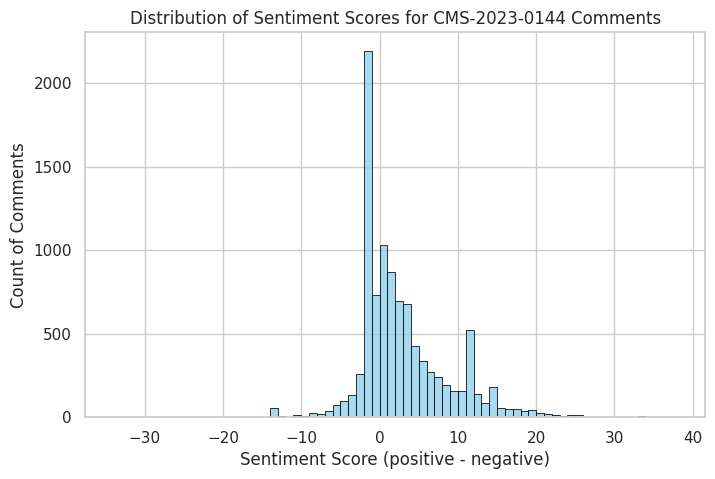

In [ ]:
# -----------------------------------------------------------------------------
# 5. VISUALIZATION OF SENTIMENT SCORE DISTRIBUTION (ggplot2-style)
# -----------------------------------------------------------------------------
# In this section, we create a histogram of the lexicon-based sentiment scores.
# This is analogous to using ggplot2 in R with geom_histogram() to inspect
# the distribution of a variable.

# Set an overall visual theme for the plots (similar to theme_minimal() in ggplot2)
sns.set_theme(style="whitegrid")

# Create a new figure and specify its size in inches
plt.figure(figsize=(8, 5))

# Draw a histogram of the sentiment_score variable.
# - data=sentiment_scores tells seaborn which DataFrame to use
# - x="sentiment_score" chooses the column to plot on the x-axis
# - binwidth=1 ensures that each bin corresponds to one integer value
# - color and edgecolor control the bar fill and border colors
sns.histplot(
    data=sentiment_scores,
    x="sentiment_score",
    binwidth=1,
    color="skyblue",
    edgecolor="black"
)

# Add a title and axis labels to make the plot self-explanatory
plt.title("Distribution of Sentiment Scores for CMS-2023-0144 Comments")
plt.xlabel("Sentiment Score (positive - negative)")
plt.ylabel("Count of Comments")

# Save the plot to a PNG file on disk (similar to ggsave() in R)
plt.savefig("sentiment_histogram_python.png", dpi=300)

# Display the plot in the notebook
plt.show()


## Step 6: Identifying the most positive and most negative comments

Once we have a numeric sentiment score for each comment, we can look more closely at the comments with the most extreme values. This helps us interpret what the sentiment scores actually mean in substantive terms.

In this step, we identify:

- the **20 most positive comments**, based on the highest values of `sentiment_score`, and  
- the **20 most negative comments**, based on the lowest values of `sentiment_score`.

We then save these subsets to separate CSV files:

- `top20_positive_comments_python.csv`  
- `top20_negative_comments_python.csv`  

These CSV files can be opened in Excel, R, or any other tool to read the full text of the most positive and most negative comments. This is similar to using `arrange()` and `slice_head()` in dplyr to sort and take the top rows.

In the code below, we use pandas’ `nlargest()` and `nsmallest()` functions to select the top and bottom 20 rows according to the `sentiment_score` column and then write the results out to disk.


In [ ]:
# -----------------------------------------------------------------------------
# 6. TOP 20 MOST POSITIVE AND MOST NEGATIVE COMMENTS
# -----------------------------------------------------------------------------
# In this section, we extract the comments with the highest and lowest
# lexicon-based sentiment scores. This is analogous to using:
#   arrange(desc(sentiment_score)) %>% slice_head(n = 20)
# and
#   arrange(sentiment_score) %>% slice_head(n = 20)
# in dplyr.

# Top 20 most positive comments
# pandas.nlargest(n, column) returns the n rows with the largest values
# in the specified column.
top20_positive = sentiment_scores.nlargest(20, "sentiment_score")

# Top 20 most negative comments
# pandas.nsmallest(n, column) returns the n rows with the smallest values.
top20_negative = sentiment_scores.nsmallest(20, "sentiment_score")

# Save the top positive and negative comments to CSV files.
# This is similar to write.csv() in R.
top20_positive.to_csv("top20_positive_comments_python.csv", index=False)
top20_negative.to_csv("top20_negative_comments_python.csv", index=False)

# Print a quick check of the top positive scores to verify that
# we indeed captured the highest sentiment values.
print("Top 5 Positive Scores:", top20_positive["sentiment_score"].head().values)


Top 5 Positive Scores: [38 37 36 36 36]


## Step 7: Grouping comments by sentiment and summarizing

So far, we have a numeric sentiment score for each comment. To better understand the overall structure of the data, it is helpful to group comments into broader categories and compute summary statistics for each group.

In this step, we:

1. **Create a categorical sentiment group** called `sentiment_group` with three levels:
   - `"Positive"` if the sentiment score is greater than 0  
   - `"Negative"` if the sentiment score is less than 0  
   - `"Neutral"` if the sentiment score is exactly 0  
2. **Count how many comments fall into each group**, to see the overall distribution of positive, negative, and neutral comments.
3. **Compute summary statistics within each group**, including:
   - the number of comments (`n`)
   - the mean and median sentiment score
   - the minimum and maximum sentiment score
4. **Calculate the percentage of comments** in each group relative to the full dataset.

The result is a comparison table that summarizes how many comments are positive, negative, or neutral, and how strong the sentiment tends to be within each category. We then save this table to a CSV file so that it can be used in reports or further analysis.


In [ ]:
# -----------------------------------------------------------------------------
# 7. GROUPING & SUMMARIZING SENTIMENT
# -----------------------------------------------------------------------------
# In this section, we convert the numeric sentiment score into a categorical
# variable ("Positive", "Negative", "Neutral") and then compute summary
# statistics for each group. This is analogous to using:
#   group_by(sentiment_group) %>%
#   summarise(...)
# in dplyr.

# Create the sentiment_group category based on sentiment_score.
# - If sentiment_score > 0   → "Positive"
# - If sentiment_score < 0   → "Negative"
# - Otherwise (== 0)         → "Neutral"
#
# np.select is a vectorized way to implement multiple conditions, similar
# to case_when() in R.
conditions = [
    sentiment_scores["sentiment_score"] > 0,
    sentiment_scores["sentiment_score"] < 0
]
choices = ["Positive", "Negative"]

sentiment_scores["sentiment_group"] = np.select(
    conditions,
    choices,
    default="Neutral"
)

# Check how many comments fall into each group.
# This is similar to table(sentiment_group) in R.
print(sentiment_scores["sentiment_group"].value_counts())

# Group by sentiment_group and compute summary statistics for sentiment_score.
# This is analogous to:
#   group_by(sentiment_group) %>%
#   summarise(
#     n = n(),
#     mean_score = mean(sentiment_score),
#     median_score = median(sentiment_score),
#     min_score = min(sentiment_score),
#     max_score = max(sentiment_score)
#   )
comparison_table = (
    sentiment_scores
    .groupby("sentiment_group")
    .agg(
        n=("sentiment_score", "count"),
        mean_score=("sentiment_score", "mean"),
        median_score=("sentiment_score", "median"),
        min_score=("sentiment_score", "min"),
        max_score=("sentiment_score", "max")
    )
    .reset_index()
)

# Compute the percentage of all comments that fall into each sentiment group.
total_rows = len(sentiment_scores)
comparison_table["perc"] = (comparison_table["n"] / total_rows) * 100

# Print the comparison table to inspect the results.
print(comparison_table)

# Save the summary table to a CSV file for later use (e.g., in reports or slides).
comparison_table.to_csv("sentiment_group_summary_python.csv", index=False)


sentiment_group
Positive    5306
Negative    3662
Neutral     1032
Name: count, dtype: int64
  sentiment_group     n  mean_score  median_score  min_score  max_score   perc
0        Negative  3662   -2.549153          -2.0        -34         -1  36.62
1         Neutral  1032    0.000000           0.0          0          0  10.32
2        Positive  5306    6.321900           4.0          1         38  53.06


## Step 8: Local AI classification of comment stance (with progress bar)

So far, we have focused on simple, lexicon-based sentiment scores. In this step, we illustrate how to use a local, open-source large language model (LLM) to classify the stance of comments toward the policy proposal, **without** using any external API keys.

We use a **zero-shot classification** model (`facebook/bart-large-mnli`) from Hugging Face. “Zero-shot” means that the model can assign text to user-defined categories even though it was never explicitly trained on those categories. Here, as a simple illustration, we ask the model to classify each comment into one of three stance labels:

- **Support** – the comment is generally supportive of the policy  
- **Oppose** – the comment is generally opposed to the policy  
- **Neutral** – the comment is neither clearly supportive nor clearly opposed  

To keep the example fast and easy to read, we:

1. Draw a random sample of 20 comments from the cleaned dataset.
2. Load the zero-shot classification pipeline with the BART MNLI model.
3. Define a helper function that:
   - truncates long comments to a reasonable length (for speed and stability),
   - sends the text to the classifier along with the candidate labels, and
   - returns the label with the highest score.
4. Apply this function to the sample using `progress_apply()`, which shows a progress bar while classifying the comments.
5. Save the resulting sample with predicted stances to a CSV file for inspection.

This provides a compact illustration of how local LLMs can be used to code public comments by stance (e.g., support vs. oppose) without manual hand-coding or external API calls.


In [ ]:
# -----------------------------------------------------------------------------
# 8. LOCAL AI (LLM) CLASSIFICATION OF COMMENT STANCE (WITH PROGRESS BAR)
# -----------------------------------------------------------------------------
# In this section, we use a local zero-shot classification model to code the
# stance of a subset of comments as "Support", "Oppose", or "Neutral".
# This does not require any external API key and runs entirely with
# open-source models via the transformers library.

from transformers import pipeline
from tqdm import tqdm  # Progress bar library for long-running operations

# Initialize tqdm integration with pandas.
# This adds .progress_apply() as a method on DataFrames and Series,
# which behaves like .apply() but shows a progress bar.
tqdm.pandas()

# -------------------------------------------------------------------------
# Draw a small sample of comments
# -------------------------------------------------------------------------
# For demonstration purposes, we work on a random sample of 20 comments
# so that the classification finishes quickly and the results are easy
# to inspect.
#
# The random_state argument ensures that we get the same sample each time
# the code is run (for reproducibility).
sample_comments = comments_clean.sample(n=20, random_state=123).copy()

print("Loading local AI model (this may take a moment the first time)...")

# -------------------------------------------------------------------------
# Set up a zero-shot classification pipeline
# -------------------------------------------------------------------------
# We use Facebook's BART-Large-MNLI model, which was trained for
# natural language inference but can be repurposed for zero-shot
# classification. Given some text and a set of candidate labels,
# the model estimates how likely each label is for that text.
#
# device=-1 forces CPU usage. If you have a GPU configured, you can
# set device=0 to run on GPU instead.
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli"
)

# Define the stance categories we want the model to classify into.
candidate_labels = ["Support", "Oppose", "Neutral"]

def classify_comment_local(text):
    """
    Classify a single comment into one of the stance categories:
    'Support', 'Oppose', or 'Neutral', using a zero-shot classifier.
    """
    # Very long texts can slow down the model or cause memory issues.
    # We truncate to the first 1024 characters for speed and stability.
    truncated_text = text[:1024]

    # Run the zero-shot classifier on the truncated text.
    result = classifier(truncated_text, candidate_labels)

    # The result contains a list of labels ordered by score (highest first),
    # so the best label is in position 0.
    top_label = result["labels"][0]
    return top_label

print("Classifying comments locally...")

# -------------------------------------------------------------------------
# Apply the AI classification to the sample with a progress bar
# -------------------------------------------------------------------------
# .progress_apply() works like .apply(), but prints a progress bar
# so we can see how many comments have been processed.
sample_comments["llm_stance"] = sample_comments["comment_text"].progress_apply(
    classify_comment_local
)

# View the first few classified comments to check the results.
print(sample_comments[["comment_text", "llm_stance"]].head())

# Save the sample with LLM-based stance labels to a CSV file.
sample_comments.to_csv("sample_comments_local_ai_stance.csv", index=False)

print("Done! Files saved.")


Loading local AI model (this may take a moment the first time)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Classifying comments locally...


100%|██████████| 20/20 [03:10<00:00,  9.50s/it]

                                           comment_text llm_stance
2656  Taking care of my residents gives me great joy...    Support
445   Centers for Medicare & Medicaid Services and D...     Oppose
9505  Centers for Medicare & Medicaid Services and D...     Oppose
332   Centers for Medicare & Medicaid Services and D...     Oppose
4168  Centers for Medicare & Medicaid Services and D...     Oppose
Done! Files saved.


## Step 9: Inspecting the most positive and most negative comments (dictionary-based method)

The numeric sentiment scores are useful, but they are much easier to interpret when we can see concrete examples of the underlying text. In this step, we take the simple lexicon-based (dictionary-based) sentiment scores and look at the comments with the most extreme values.

Specifically, we identify:

- the **3 most positive comments**, i.e., those with the highest `sentiment_score`, and  
- the **3 most negative comments**, i.e., those with the lowest `sentiment_score`.

Rather than just looking at the numbers, we print both the **full comment text** and the corresponding `sentiment_score` for each example. This allows us to check whether the dictionary-based method is behaving in a sensible way and to see which words and phrases drive very positive or very negative scores.

This step directly addresses the concern that, if only a small snippet is shown, it can be difficult to see what in the text makes the sentiment positive or negative. Here we explicitly show the full comments for a small number of extreme cases.


In [ ]:
# --- 9. Show most positive/negative comments (dictionary-based method) ---
# In this section, we inspect a small number of comments with the most
# extreme dictionary-based sentiment scores, and we print the full text
# so that we can see why the score is very positive or very negative.

# Select the 3 comments with the highest sentiment_score
top3_positive = (
    comments_clean
    .sort_values("sentiment_score", ascending=False)
    [["comment_text", "sentiment_score"]]
    .head(3)
)

# Select the 3 comments with the lowest sentiment_score
top3_negative = (
    comments_clean
    .sort_values("sentiment_score", ascending=True)
    [["comment_text", "sentiment_score"]]
    .head(3)
)

print("\nTop 3 MOST POSITIVE (dictionary-based):\n")
for i, row in top3_positive.iterrows():
    print("=" * 80)
    print(f"Sentiment score: {row['sentiment_score']}")
    print("Comment text:\n")
    # Print the full comment text (no truncation)
    print(row["comment_text"])
    print("\n")

print("\nTop 3 MOST NEGATIVE (dictionary-based):\n")
for i, row in top3_negative.iterrows():
    print("=" * 80)
    print(f"Sentiment score: {row['sentiment_score']}")
    print("Comment text:\n")
    # Again, print the full comment text
    print(row["comment_text"])
    print("\n")



Top 3 MOST POSITIVE (dictionary-based):

Sentiment score: 38
Comment text:

Dear Administrator Brooks-LaSure:

I am writing to express my deep concerns and strong objection to the proposed minimum staffing levels for long-term care facilities. As someone deeply committed to providing quality care to our elderly residents and as a dedicated member of the long-term care community, I am compelled to share my perspective on this matter.
 
I have been working in the long-term care industry for two years, and my current role is staff accountant at Nexion Health Management, Inc., located in Sykesville, MD. We own and operate 56 skilled nursing and assisted living care facilities in the states of Louisiana, Mississippi, and Texas. (Add your department's specific support of Nexion facilities such as:  "The Accounts Payable Department provides technology and all associated services to Nexion facilities to ensure that the vendors that provide products and services to our facilities are properly 

## Step 10: Single-example zero-shot classification (illustration)

In addition to running the local AI classifier on a sample of comments, it is helpful to walk through a **single, concrete example** in detail. This makes it easier to see exactly what the model is doing.

In this step, we:

1. Load the same zero-shot classification model (`facebook/bart-large-mnli`) that we used earlier.
2. Define a simple set of stance labels: `"Support"`, `"Oppose"`, and `"Neutral"`.
3. Take the **first comment** in the cleaned dataset and print its full text.
4. Pass this text to the zero-shot classifier along with our three labels.
5. Examine the model’s output, including the predicted label and the scores for each candidate label.

This small example illustrates, in a transparent way, how a zero-shot classifier maps a single comment to a stance category and how confident it is in each possible label.


In [ ]:
# --- 10. Zero-shot classification example (single comment) ---
from transformers import pipeline

print("Loading zero-shot classifier...")

# Set up the same zero-shot classification model as before.
zsc = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli"
)

# Define the stance labels we want the model to choose among.
labels = ["Support", "Oppose", "Neutral"]

print("\nZero-shot example on a single comment:")

# Take the first comment in the cleaned dataset.
example = comments_clean["comment_text"].iloc[0]

# Print the full text of the example comment so we can see what the model is reading.
print("\nTEXT:\n")
print(example)

# Run the zero-shot classifier on this example.
# The model returns a dictionary with:
#   - 'labels': candidate labels sorted by score (best first)
#   - 'scores': the corresponding probabilities
result = zsc(example, labels)

print("\nRESULT (raw output):")
print(result)

# For readability, we can also print the top label and a simple summary table.
top_label = result["labels"][0]
top_score = result["scores"][0]

print("\nPredicted top label:", top_label)
print("Top label score:", round(top_score, 3))

print("\nAll label scores:")
for label, score in zip(result["labels"], result["scores"]):
    print(f"  {label:8s} : {score:.3f}")


Loading zero-shot classifier...


Device set to use cpu



Zero-shot example on a single comment:

TEXT:

Centers for Medicare & Medicaid Services and Department of Health and Human Services (HHS). Official Comment,

The result of private equity ownership in companies caring for vulnerable populations is downright grisly, including deadly neglect and abuse in residential centers for the severely disabled, denying care to medicare and medicaid patients with life-threatening eating disorders, and padding bills for wheelchairs.



While we applaud the steps taken by the Biden administration to require a minimum staff-to-patient ratio in nursing homes, I believe the ratio MUST be stronger to protect patients and staff. 



Private equity companies are drawn to health care because of the opportunities they see in market failures, inconsistent payment policies, and lax regulation or enforcement that can be exploited for financial gain. In addition, the imperative of the PE business model is to boost profits quickly, often by reducing costs, which i

## Step 11: Summarizing long comments with an open-source LLM

Some public comments are very long and time-consuming to read in full. In large-scale analyses, it can be useful to generate short summaries of these long comments so that researchers and policymakers can quickly understand the main points.

In this step, we demonstrate how to use an open-source summarization model to create approximately 50-word summaries of long comments:

1. We load a summarization pipeline based on the `facebook/bart-large-cnn` model.
2. We identify “long” comments as those with more than 500 words in `comment_text`.
3. If at least one long comment exists, we:
   - take the first long comment,
   - report its original word count,
   - print a portion of the original text (so we can see what is being summarized),
   - and then generate a short summary using the LLM.
4. We print the resulting summary so that we can compare the original text and the compressed version.

This illustrates how summarization models can be integrated into an NLP workflow to make lengthy public comments more accessible, while still preserving the key ideas in a much shorter format.


In [ ]:
# --- 11. Summaries for long comments (approx. 50-word summary) ---

from transformers import pipeline

# Set up the summarization pipeline using an open-source BART model.
summarizer = pipeline(
    "summarization",
    model="facebook/bart-large-cnn"
)

# -------------------------------------------------------------------------
# Find long comments
# -------------------------------------------------------------------------
# Here we define "long" comments as those whose text has more than 500 words.
# We compute the word count by splitting comment_text on whitespace and
# taking the length of the resulting list.
long_comments = comments_clean[
    comments_clean["comment_text"].str.split().apply(len) > 500
]

print(f"Found {len(long_comments)} long comments.")

if len(long_comments) > 0:
    # Take the first long comment as an example.
    text = long_comments["comment_text"].iloc[0]
    word_count = len(text.split())
    print("\nOriginal length:", word_count, "words")

    # Optionally, print a portion of the original text so we can see
    # what the model is summarizing. We do not print all 500+ words
    # on screen to avoid overwhelming the output, but we show a sizable
    # excerpt (e.g., first 400 characters).
    print("\nORIGINAL TEXT (excerpt):\n")
    print(text[:400] + ("..." if len(text) > 400 else ""))

    # Generate a short summary using the LLM.
    # max_length and min_length are in tokens, not exact words,
    # but here we target a short paragraph roughly equivalent to
    # about 30–50 words.
    summary = summarizer(
        text,
        max_length=80,   # upper bound on summary length (in tokens)
        min_length=40,   # lower bound on summary length
        do_sample=False
    )

    print("\nSUMMARY (~50 words):\n")
    print(summary[0]["summary_text"])
else:
    print("\nNo comments with more than 500 words were found in the dataset.")


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Found 704 long comments.

Original length: 530 words

ORIGINAL TEXT (excerpt):

We know that understaffing is a major factor in the harm that residents experience every year in long-term care facilities. We know this not just because of research done in the last year but an extensive body of scientific study that has accumulated pointing clearly to a recommendation of at least 4.1 hours per resident day (hprd) of direct care nursing staff time that are needed just to prevent ...

SUMMARY (~50 words):

Ombudsman says understaffing is a major factor in the harm that residents experience every year in long-term care facilities. At least 4.1 hours per resident day (hprd) of direct care nursing staff time that are needed just to prevent poor outcomes, i.e harm.


## Step 12: Comparing two open-source LLMs for sentiment classification

Different open-source LLMs can produce different results even when given the same input text and the same candidate labels. To illustrate this, we run a simple side-by-side comparison of two models:

- `facebook/bart-large-mnli`
- `microsoft/deberta-v3-base`

We use both models in a **zero-shot classification** setup with the same two labels:

- `"Positive"`
- `"Negative"`

In this step, we:

1. Load both zero-shot classification pipelines.
2. Select a single example comment from `comments_clean`.
3. Print the full text of the comment so we can see what is being classified.
4. Run the same text through both models with the same label set.
5. Examine how each model scores the `"Positive"` and `"Negative"` labels, and which label it ranks highest.

This small example shows how different LLM architectures (BART vs. DeBERTa) can yield slightly different predictions or confidence levels when applied to the same public comment and sentiment labels.


In [ ]:
# --- 12. Compare two open-source LLMs for sentiment (zero-shot setup) ---

from transformers import pipeline

# Set up two different zero-shot classification models:
#  - facebook/bart-large-mnli  (BART-based)
#  - microsoft/deberta-v3-base (DeBERTa-based)
print("Loading zero-shot models...")

model1 = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli"
)

model2 = pipeline(
    "zero-shot-classification",
    model="microsoft/deberta-v3-base"
)

# We will compare how each model assigns sentiment to a single comment
# using only two candidate labels: "Positive" and "Negative".
labels = ["Positive", "Negative"]

# Select a sample comment from the cleaned dataset.
sample = comments_clean["comment_text"].iloc[5]

print("\nTEXT (full comment):\n")
print(sample)

# -------------------------------------------------------------------------
# Run the first model (BART) on the sample
# -------------------------------------------------------------------------
print("\nModel 1: facebook/bart-large-mnli")
result1 = model1(sample, labels)

# Print raw output (optional, for debugging)
# print(result1)

# For readability, show the labels and scores in a simple format.
print("\nModel 1 label scores:")
for label, score in zip(result1["labels"], result1["scores"]):
    print(f"  {label:8s} : {score:.3f}")

print("\nModel 1 predicted top label:",
      result1["labels"][0],
      "with score",
      round(result1["scores"][0], 3))

# -------------------------------------------------------------------------
# Run the second model (DeBERTa) on the same sample
# -------------------------------------------------------------------------
print("\nModel 2: microsoft/deberta-v3-base")
result2 = model2(sample, labels)

print("\nModel 2 label scores:")
for label, score in zip(result2["labels"], result2["scores"]):
    print(f"  {label:8s} : {score:.3f}")

print("\nModel 2 predicted top label:",
      result2["labels"][0],
      "with score",
      round(result2["scores"][0], 3))


Loading zero-shot models...


Device set to use cpu


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cpu
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.



TEXT (full comment):

I believe that this nation is in a terrible staffing crisis and this new requirement will not help. It's hard enough to get staff to care for the residents without this new rule that will make things more difficult to staff and care for our patients.

Model 1: facebook/bart-large-mnli


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Model 1 label scores:
  Negative : 0.935
  Positive : 0.065

Model 1 predicted top label: Negative with score 0.935

Model 2: microsoft/deberta-v3-base

Model 2 label scores:
  Negative : 0.500
  Positive : 0.500

Model 2 predicted top label: Negative with score 0.5
